<a href="https://colab.research.google.com/github/JCaballerot/Recommender-Systems/blob/main/PCA_Recommender/PCA_Collaborative_Filtering_Last_fm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<h1 align=center><font size = 5> PCA Collaborative Filtering - Last.fm </font></h1>

---

**Índice**

- 1. Introducción
- 2. Carga y Preparación de Datos
- 3. Creación de la Matriz Usuario-Artista
- 4. Aplicación de PCA
- 6. Conclusiones
- 7. Desafío


---

## 1. Introducción

En este laboratorio, aplicaremos Análisis de Componentes Principales (PCA) sobre los datos de interacciones usuario-artista en Last.fm para reducir la dimensionalidad y obtener patrones latentes. Exploraremos cómo PCA puede ayudar a encontrar relaciones subyacentes entre los artistas basadas en las preferencias de los usuarios y a mejorar la eficiencia en la creación de sistemas de recomendación.

## 2. Configuración del Entorno

Primero, necesitamos asegurarnos de que tenemos las librerías necesarias para realizar PCA y visualizar los resultados.

In [1]:
%%capture
# Instalar las librerías necesarias
!pip install matplotlib pandas scikit-learn seaborn


Importamos las librerías que utilizaremos a lo largo del laboratorio:



In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


## 3. Carga y Preparación de Datos



**Carga de Datos**

Cargamos los datos de interacciones usuario-artista desde el archivo lastfm.csv. Este archivo contiene información sobre la cantidad de veces que un usuario ha escuchado a un determinado artista.

In [3]:
from google.colab import files
files.upload()  # Sube tu archivo kaggle.json aquí

# Crear la carpeta .kaggle y mover el archivo
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [4]:
!kaggle datasets download -d japarra27/lastfm-dataset
!unzip lastfm-dataset.zip


Dataset URL: https://www.kaggle.com/datasets/japarra27/lastfm-dataset
License(s): unknown
100% 1.83G/1.83G [01:06<00:00, 31.9MB/s]
100% 1.83G/1.83G [01:06<00:00, 29.4MB/s]
Archive:  lastfm-dataset.zip
  inflating: items.parquet           
  inflating: lastfm-dataset-1K/lastfm-dataset-1K/README.txt  
  inflating: lastfm-dataset-1K/lastfm-dataset-1K/userid-profile.tsv  
  inflating: lastfm-dataset-1K/lastfm-dataset-1K/userid-timestamp-artid-artname-traid-traname.tsv  
  inflating: lastfm_union.parquet    
  inflating: users.parquet           


In [5]:
# Cargar el dataset Last.fm
data = pd.read_parquet("lastfm_union.parquet")[:1_000_000]
data.head()

,user_id,timestamp,artist_id,artist_name,track_id,track_name,gender,age,country,registered
0,user_000001,2009-05-04 23:08:57+00:00,f1b1cf71-bd35-4e99-8624-24a6e15f133a,Deep Dish,None,Fuck Me Im Famous (Pacha Ibiza)-09-28-2007,M,NaN,JAPAN,2006-08-13
1,user_000001,2009-05-04 13:54:10+00:00,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,åæ¬é¾ä¸,None,Composition 0919 (Live_2009_4_15),M,NaN,JAPAN,2006-08-13
2,user_000001,2009-05-04 13:52:04+00:00,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,åæ¬é¾ä¸,None,Mc2 (Live_2009_4_15),M,NaN,JAPAN,2006-08-13
3,user_000001,2009-05-04 13:42:52+00:00,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,åæ¬é¾ä¸,None,Hibari (Live_2009_4_15),M,NaN,JAPAN,2006-08-13
4,user_000001,2009-05-04 13:42:11+00:00,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,åæ¬é¾ä¸,None,Mc1 (Live_2009_4_15),M,NaN,JAPAN,2006-08-13


**Exploración de Datos**

Verificamos la cantidad de interacciones, usuarios y artistas únicos en el dataset.



In [6]:
# Dimensiones del dataset
print(f"El dataset tiene {data.shape[0]} filas y {data.shape[1]} columnas.")



El dataset tiene 1000000 filas y 10 columnas.


In [7]:
# Número de usuarios únicos
num_users = data['user_id'].nunique()
print(f"Hay {num_users} usuarios únicos.")


Hay 41 usuarios únicos.


In [8]:
# Número de artistas únicos
num_artists = data['artist_id'].nunique()
print(f"Hay {num_artists} artistas únicos.")

Hay 19088 artistas únicos.


**Conversión a Matriz Usuario-Artista**

Para aplicar PCA, necesitamos construir una matriz usuario-artista, donde las filas representan a los usuarios y las columnas a los artistas. El valor en cada celda representa cuántas veces el usuario ha escuchado a un artista.

In [31]:
# Contar cuántas veces cada usuario ha escuchado a cada artista
user_artist_interactions = data.groupby(['user_id', 'artist_name']).size().unstack(fill_value=0)

# Mostrar la matriz usuario-artista
user_artist_interactions.head()


artist_name,! Www.Polskie-Mp3.Tk ! Katarzyna Groniec,!!!,!4,!Deladap,#####,#Poundsign#,$Olal,$Wingin' Utter$,&Gt;:50= M;L7K,&Lt;Beha&Gt; X-Scape,...,é«æ©ã¿ãªã,é«­ï¼Higeï¼,é¬¼æã¡ã²ã,é·ºå·£è©©é,é»å¤©ç¿±,é»å¤¢,ë¬¸í¬ì¤,ìíì§,ìë ìë,ï¼«ï½ï½ ï½
user_id,,,,,,,,,,,,,,,,,,,,,
user_000001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
user_000002,0,0,0,3,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
user_000003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
user_000004,0,48,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
user_000005,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


**Visualización de la Distribución Long Tail**

Visualizamos la distribución de las escuchas de los artistas para observar si hay una distribución long tail, donde pocos artistas tienen muchas escuchas y la mayoría tiene pocas.

In [22]:
# Contar cuántas veces ha sido escuchado cada artista directamente desde la tabla original
artist_listen_counts = data.groupby('artist_name').size().sort_values(ascending=False)
artist_listen_counts.head()

,0
artist_name,
Kanye West,27267
Dir En Grey,12006
ã ãã¯,7789
Radiohead,7157
Nine Inch Nails,6711


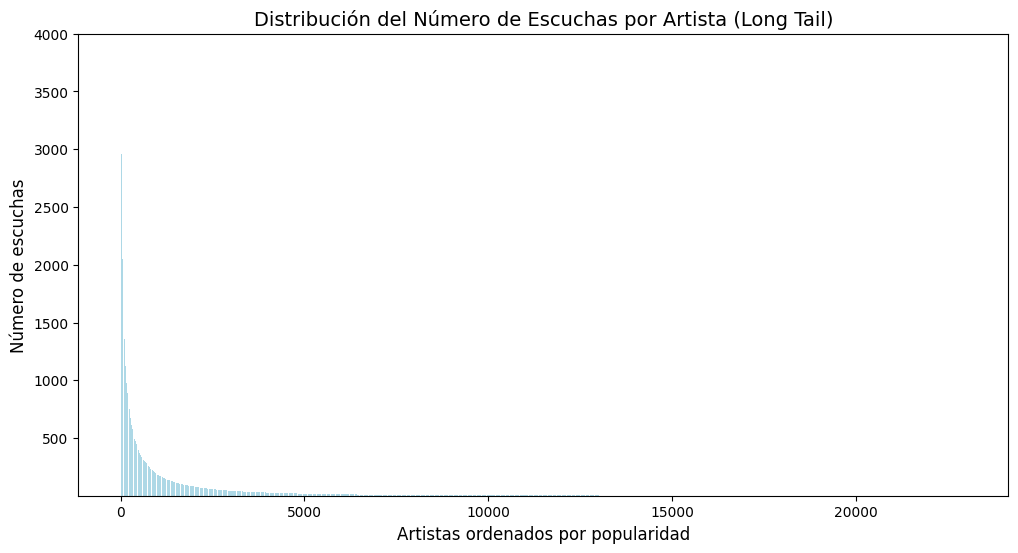

In [11]:
# Generar el gráfico de barras para visualizar el long tail
plt.figure(figsize=(12, 6))
plt.bar(range(len(artist_listen_counts)), artist_listen_counts, color='lightblue')
plt.title('Distribución del Número de Escuchas por Artista (Long Tail)', fontsize=14)
plt.xlabel('Artistas ordenados por popularidad', fontsize=12)
plt.ylabel('Número de escuchas', fontsize=12)
plt.ylim(1, 4000)  # Cambia estos valores según el rango que quieras mostrar
#plt.yscale('log')  # Escala logarítmica para resaltar la distribución long tail
plt.show()


**Filtrado de Datos**

In [12]:
artist_listen_counts.tail()

,0
artist_name,
Sarah Dash,1
George Arthur Elliott,1
George Baker Selection,1
Sara Tavares,1
! Www.Polskie-Mp3.Tk ! Katarzyna Groniec,1


Filtramos los datos para enfocarnos en los artistas que han sido escuchados al menos un número mínimo de veces. Esto reduce la esparsidad de la matriz y mejora la calidad del análisis.

In [16]:
# Establecer un número mínimo de escuchas por artista
min_listens_per_artist = 50

# Filtrar los artistas con al menos min_listens_per_artist escuchas directamente en el dataframe
artist_counts = data.groupby('artist_name').size()
popular_artists = artist_counts[artist_counts >= min_listens_per_artist].index




artist_name,!!!,(HÉd) P.E.,(Ð¡) Ð¥Ð¾Ñ Ð¥ÑÐ°Ð¼Ð° Ð Ð¾Ð¶Ð´ÐµÑÑÐ²Ð° Ð¥ÑÐ¸ÑÑ,...And You Will Know Us By The Trail Of Dead,...But Alive,10Cc,12 Rounds,16 Horsepower,2 Dope,2H Company,...,ç¢éé¡å­,ç³äºå¦¥å¸«,è éããå­,è¿è¤æµ©æ²»,é·æ¸å,é -Miyavi-,é«æ¨æ­£å,é¬¼æã¡ã²ã,é·ºå·£è©©é,é»å¤¢
user_id,,,,,,,,,,,,,,,,,,,,,
user_000001,0,0,0,0,0,0,0,0,0,0,...,169,0,0,0,0,0,152,0,0,0
user_000002,0,0,0,42,84,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
user_000003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
user_000004,48,0,0,0,0,0,8,3,0,0,...,0,0,0,0,0,0,0,0,0,0
user_000005,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Este análisis de las interacciones por usuario nos permitirá ver cuántos usuarios son muy activos (con muchas interacciones) y cuántos son menos activos (con pocas interacciones), siguiendo la típica distribución long tail en este tipo de datos.

In [20]:
# Contar cuántas veces ha sido escuchado cada artista directamente desde la tabla original
user_interaction_counts = data.groupby('user_id').size().sort_values(ascending=False)
print(user_interaction_counts.head())

user_id
user_000033    96436
user_000012    75876
user_000021    70446
user_000002    57438
user_000022    51474
dtype: int64


In [21]:
print(user_interaction_counts.tail())

user_id
user_000020    4668
user_000036    4242
user_000027    3767
user_000007    2454
user_000014     354
dtype: int64


In [ ]:
# Filtrar el dataframe original para incluir solo los artistas populares
filtered_data = data[data['artist_name'].isin(popular_artists)]

**Proceso de enmascaramiento**

In [86]:
from sklearn.model_selection import train_test_split

# Enmascarar el 20% de canciones preferidas por usuario
def mask_preferred_songs(df, test_size=0.2):
    train_list = []
    test_list = []

    # Iterar sobre cada usuario
    for user_id, user_data in df.groupby('user_id'):
        # Dividir las canciones de cada usuario en entrenamiento y prueba (preferencias enmascaradas)
        train_data, test_data = train_test_split(user_data, test_size=test_size, random_state=42)
        train_list.append(train_data)
        test_list.append(test_data)

    # Combinar los resultados en DataFrames
    train_df = pd.concat(train_list)
    test_df = pd.concat(test_list)

    return train_df, test_df

# Aplicar la función al dataset original
train_data, test_data = mask_preferred_songs(filtered_data, test_size=0.05)


In [89]:
# Agrupar y sumar los valores en train_data
train_data = train_data.groupby(['user_id', 'track_name'])['track_id'].count().reset_index()

# Agrupar y sumar los valores en test_data
test_data = test_data.groupby(['user_id', 'track_name'])['track_id'].count().reset_index()


In [90]:
test_data.head()

,user_id,track_name,track_id
0,user_000001,'84 Pontiac Dream,1
1,user_000001,(D)Ecaying Beauty,1
2,user_000001,(Nice Dream),1
3,user_000001,15 Step,1
4,user_000001,16,1


In [91]:

# Ahora que tenemos los datos filtrados, creamos la matriz usuario-artista
user_artist_matrix_filtered = train_data.groupby(['user_id', 'track_name']).sum().unstack(fill_value=0)

# Mostrar la matriz filtrada
user_artist_matrix_filtered.head()

track_id               \
track_name    ~Kuuhaku~ ! (Foreword)   
user_id                                
user_000001           0            0   
user_000002           0            0   
user_000003           0            0   
user_000004           0            0   
user_000005           0            0   

                                                            \
track_name  # 173 - The Stills, Novillero, Fred Eaglesmith   
user_id                                                      
user_000001                                              0   
user_000002                                              0   
user_000003                                              0   
user_000004                                              0   
user_000005                                              0   

                                                               \
track_name  # 174 - The Organ, Sloan, Jill Barber #1 #1 Crush   
user_id                                                         
user_000001                                     0  0        0   
user_000002                                     0  0        0   
user_000003                                     0  0        0   
user_000004                                     0  0        1   
user_000005                                     0  0        0   

                                                                 \
track_name  #1 Crush (Original Version) #1 Hit Jam #1 Must Have   
user_id                                                           
user_000001                           0          0            0   
user_000002                           0          0            0   
user_000003                           0          0            0   
user_000004                           1          0            0   
user_000005                           0          0            0   

                                     ...                     \
track_name  #102 - Saskatoon Secret  ... é»ããªã«ãã§   
user_id                              ...                      
user_000001                       0  ...                  0   
user_000002                       0  ...                  0   
user_000003                       0  ...                  0   
user_000004                       0  ...                  0   
user_000005                       0  ...                  0   

                                                                           \
track_name  é»ãæ¶ -Tv Live Edition- é»ç«é é¼å ë (The Betray)   
user_id                                                                     
user_000001                           0         0      0                0   
user_000002                           0         0      0                0   
user_000003                           0         0      0                0   
user_000004                           1         0      0                0   
user_000005                           0         0      0                0   

                                               \
track_name  íë¡¤ë¡ê·¸ - ë¨¼ê¸¸ åº -é¿é   
user_id                                         
user_000001                                 0   
user_000002                                 0   
user_000003                                 0   
user_000004                                 0   
user_000005                                 0   

                                                      \
track_name  ï¼´ouch - A Mountain Of One Peyote Remix   
user_id                                                
user_000001                                        1   
user_000002                                        0   
user_000003                                        0   
user_000004                                        0   
user_000005                                        0   

                                                   \
track_name  ï½¢HÃMÃ-Crash-Trap@ï½£ ï¼A Typeï¼   
user_id                                             
user_000001     

## 4. Aplicación de PCA


### 4.1. Proyección de los Datos
Aplicamos PCA a la matriz usuario-artista filtrada para reducir la dimensionalidad. Esto nos permitirá proyectar los usuarios en un espacio con menos dimensiones, explicando la mayor parte de la varianza en los datos.

In [92]:
from sklearn.preprocessing import MinMaxScaler

# Escalar los datos entre 0 y 1 utilizando MinMaxScaler
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(user_artist_matrix_filtered)

In [93]:
# Convertir el array estandarizado de vuelta a un DataFrame con los índices y columnas originales
data_scaled_df = pd.DataFrame(data_scaled, index=user_artist_matrix_filtered.index, columns=user_artist_matrix_filtered.columns)

# Mostrar las primeras filas del DataFrame estandarizado
data_scaled_df.head()

track_id               \
track_name    ~Kuuhaku~ ! (Foreword)   
user_id                                
user_000001         0.0          0.0   
user_000002         0.0          0.0   
user_000003         0.0          0.0   
user_000004         0.0          0.0   
user_000005         0.0          0.0   

                                                            \
track_name  # 173 - The Stills, Novillero, Fred Eaglesmith   
user_id                                                      
user_000001                                            0.0   
user_000002                                            0.0   
user_000003                                            0.0   
user_000004                                            0.0   
user_000005                                            0.0   

                                                                 \
track_name  # 174 - The Organ, Sloan, Jill Barber   #1 #1 Crush   
user_id                                                           
user_000001                                   0.0  0.0      0.0   
user_000002                                   0.0  0.0      0.0   
user_000003                                   0.0  0.0      0.0   
user_000004                                   0.0  0.0      1.0   
user_000005                                   0.0  0.0      0.0   

                                                                 \
track_name  #1 Crush (Original Version) #1 Hit Jam #1 Must Have   
user_id                                                           
user_000001                         0.0        0.0          0.0   
user_000002                         0.0        0.0          0.0   
user_000003                         0.0        0.0          0.0   
user_000004                         1.0        0.0          0.0   
user_000005                         0.0        0.0          0.0   

                                     ...                     \
track_name  #102 - Saskatoon Secret  ... é»ããªã«ãã§   
user_id                              ...                      
user_000001                     0.0  ...                0.0   
user_000002                     0.0  ...                0.0   
user_000003                     0.0  ...                0.0   
user_000004                     0.0  ...                0.0   
user_000005                     0.0  ...                0.0   

                                                                           \
track_name  é»ãæ¶ -Tv Live Edition- é»ç«é é¼å ë (The Betray)   
user_id                                                                     
user_000001                         0.0       0.0    0.0              0.0   
user_000002                         0.0       0.0    0.0              0.0   
user_000003                         0.0       0.0    0.0              0.0   
user_000004                         1.0       0.0    0.0              0.0   
user_000005                         0.0       0.0    0.0              0.0   

                                               \
track_name  íë¡¤ë¡ê·¸ - ë¨¼ê¸¸ åº -é¿é   
user_id                                         
user_000001                               0.0   
user_000002                               0.0   
user_000003                               0.0   
user_000004                               0.0   
user_000005                               0.0   

                                                      \
track_name  ï¼´ouch - A Mountain Of One Peyote Remix   
user_id                                                
user_000001                                      1.0   
user_000002                                      0.0   
user_000003                                      0.0   
user_000004                                      0.0   
user_000005                                      0.0   

                                                   \
track_name  ï½¢HÃMÃ-Crash-Trap@ï½£ ï¼A Typeï¼   
user_id                                             


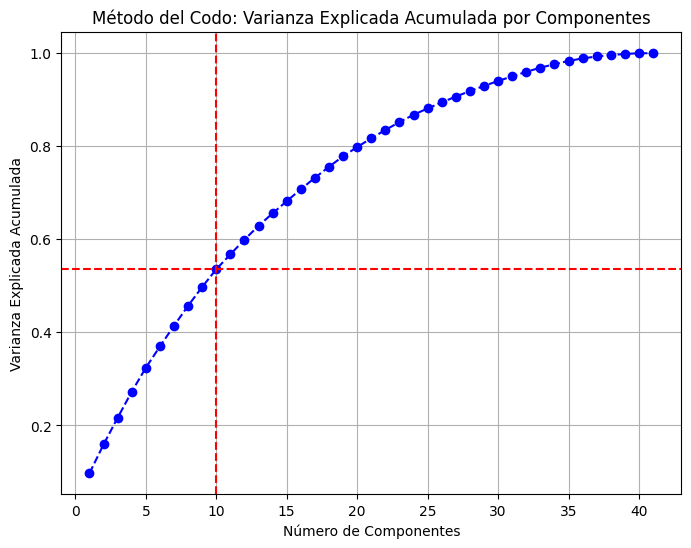

In [94]:
# Aplicar PCA sin limitar el número de componentes para calcular la varianza explicada
pca = PCA()
pca.fit(data_scaled)

# Varianza explicada por cada componente
explained_variance = pca.explained_variance_ratio_

# Varianza explicada acumulada
explained_variance_cumsum = np.cumsum(explained_variance)

# Graficar el método del codo (elbow method)
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance_cumsum) + 1), explained_variance_cumsum, marker='o', linestyle='--', color='b')
plt.title('Método del Codo: Varianza Explicada Acumulada por Componentes')
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Explicada Acumulada')
plt.grid(True)

# Dibujar líneas verticales y horizontales para ayudar a ver el codo
plt.axvline(x=10, color='r', linestyle='--')  # Ejemplo, ajustar según los datos
plt.axhline(y=explained_variance_cumsum[9], color='r', linestyle='--')  # Ejemplo, ajustar según los datos

plt.show()

### 4.2. Varianza Explicada por los Componentes Principales


Es importante observar cuánta varianza está explicada por cada componente principal, para entender cuántos componentes necesitamos mantener.

In [95]:
# Aplicar PCA para reducir la dimensionalidad a 10 componentes principales
pca = PCA(n_components=10)
pca_result = pca.fit_transform(data_scaled)


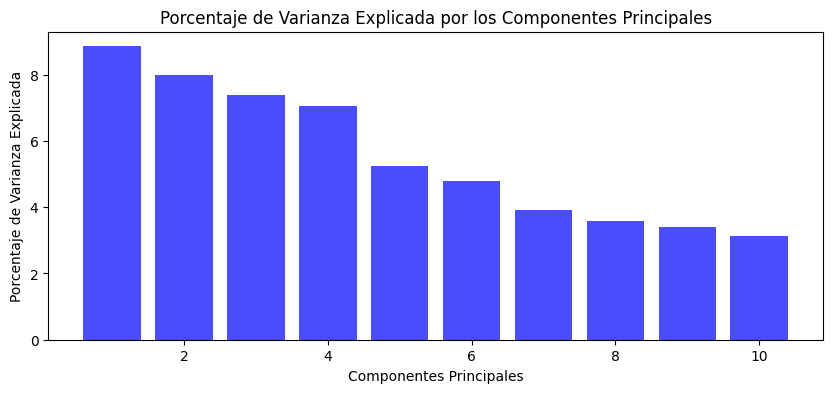

In [76]:
# Varianza explicada por cada componente
explained_variance = pca.explained_variance_ratio_

# Gráfico de barras para mostrar la varianza explicada
plt.figure(figsize=(10, 4))
plt.bar(range(1, 11), explained_variance * 100, color='blue', alpha=0.7)
plt.title('Porcentaje de Varianza Explicada por los Componentes Principales')
plt.xlabel('Componentes Principales')
plt.ylabel('Porcentaje de Varianza Explicada')
plt.show()


**Reconstrucción de la matriz original**

In [96]:
# Reconstruir la matriz original
data_reconstructed = pca.inverse_transform(pca_result)

# Deshacer la estandarización para obtener los valores originales
#data_reconstructed_original = scaler.inverse_transform(data_reconstructed)

# Convertir la matriz reconstruida de vuelta a un DataFrame
user_artist_matrix_reconstructed = pd.DataFrame(data_reconstructed,
                                                index=user_artist_matrix_filtered.index,
                                                columns=user_artist_matrix_filtered.columns)

In [97]:
user_artist_matrix_reconstructed.head()

track_id               \
track_name    ~Kuuhaku~ ! (Foreword)   
user_id                                
user_000001    0.014268     0.034106   
user_000002    0.001214    -0.050075   
user_000003   -0.007148     0.026031   
user_000004    0.007665     0.024863   
user_000005    0.003810     0.033440   

                                                            \
track_name  # 173 - The Stills, Novillero, Fred Eaglesmith   
user_id                                                      
user_000001                                      -0.002774   
user_000002                                      -0.001427   
user_000003                                       0.001326   
user_000004                                      -0.006294   
user_000005                                      -0.004407   

                                                                       \
track_name  # 174 - The Organ, Sloan, Jill Barber        #1  #1 Crush   
user_id                                                                 
user_000001                             -0.002893  0.098893  0.064580   
user_000002                             -0.001700 -0.045240 -0.010381   
user_000003                              0.004073  0.071559  0.043675   
user_000004                              0.024132  0.130897  0.098505   
user_000005                             -0.002770  0.096054  0.058190   

                                                                 \
track_name  #1 Crush (Original Version) #1 Hit Jam #1 Must Have   
user_id                                                           
user_000001                    0.028969   0.071305     0.024547   
user_000002                    0.040864  -0.060514     0.020776   
user_000003                    0.024997   0.044892     0.021865   
user_000004                    0.033827   0.062590     0.039549   
user_000005                    0.028107   0.067769     0.023379   

                                     ...                     \
track_name  #102 - Saskatoon Secret  ... é»ããªã«ãã§   
user_id                              ...                      
user_000001               -0.002774  ...           0.014268   
user_000002               -0.001427  ...           0.001214   
user_000003                0.001326  ...          -0.007148   
user_000004               -0.006294  ...           0.007665   
user_000005               -0.004407  ...           0.003810   

                                                                              \
track_name  é»ãæ¶ -Tv Live Edition- é»ç«é    é¼å ë (The Betray)   
user_id                                                                        
user_000001                    0.028969  0.014268  0.014268         0.014268   
user_000002                    0.040864  0.001214  0.001214         0.001214   
user_000003                    0.024997 -0.007148 -0.007148        -0.007148   
user_000004                    0.033827  0.007665  0.007665         0.007665   
user_000005                    0.028107  0.003810  0.003810         0.003810   

                                               \
track_name  íë¡¤ë¡ê·¸ - ë¨¼ê¸¸ åº -é¿é   
user_id                                         
user_000001                          0.014268   
user_000002                          0.001214   
user_000003                         -0.007148   
user_000004                          0.007665   
user_000005                          0.003810   

                                                      \
track_name  ï¼´ouch - A Mountain Of One Peyote Remix   
user_id                                                
user_000001                                 0.039468   
user_000002                                -0.030182   
user_000003                                 0.025057   
user_000004                                 0.028979   
user_000005                                 0.037653   

                                                   \
track_name  ï½¢HÃMÃ-Crash-Trap@ï

In [98]:
# Convertir la matriz reconstruida a una estructura con columnas 'user_id', 'track_name' y 'rating'
reconstructed_df = user_artist_matrix_reconstructed.stack().reset_index()

# Renombrar las columnas para que reflejen 'user_id', 'track_name' y 'rating'
reconstructed_df.columns = ['user_id', 'track_name', 'reconstructed_rating']

# Mostrar las primeras filas del DataFrame final
reconstructed_df.head()


<ipython-input-98-c3659ec25751>:2: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  reconstructed_df = user_artist_matrix_reconstructed.stack().reset_index()


,user_id,track_name,reconstructed_rating
0,user_000001,~Kuuhaku~,0.014268
1,user_000001,! (Foreword),0.034106
2,user_000001,"# 173 - The Stills, Novillero, Fred Eaglesmith",-0.002774
3,user_000001,"# 174 - The Organ, Sloan, Jill Barber",-0.002893
4,user_000001,#1,0.098893


**Generar las recomendaciones**

Para generar las recomendaciones, seleccionamos las canciones que tienen un mayor valor en la matriz reconstruida, especialmente para aquellas canciones que estaban enmascaradas (20% en el conjunto de prueba).



In [99]:
# Paso 1: Identificar las canciones ya escuchadas por usuario en el conjunto de entrenamiento (train_data)
# Crear un set de pares (user_id, track_name) del conjunto de entrenamiento para facilitar el filtrado
already_listened = set(zip(train_data['user_id'], train_data['track_name']))

# Paso 2: Filtrar las recomendaciones, eliminando las canciones ya escuchadas
# Filtrar los pares (user_id, track_name) que ya están en el conjunto de entrenamiento
reconstructed_df_filtered = reconstructed_df[~reconstructed_df.set_index(['user_id', 'track_name']).index.isin(already_listened)]

# Paso 3: Quedarse con las 10 mejores recomendaciones por usuario
# Ordenar las recomendaciones por usuario y valor reconstruido (rating), en orden descendente
reconstructed_df_filtered = reconstructed_df_filtered.sort_values(by=['user_id', 'reconstructed_rating'], ascending=[True, False])

# Mantener solo las 10 mejores recomendaciones por usuario
top_10_recommendations = reconstructed_df_filtered.groupby('user_id').head(10).reset_index(drop=True)

# Mostrar las primeras filas del resultado final
top_10_recommendations.head(20)


,user_id,track_name,reconstructed_rating
0,user_000001,Angel,0.513379
1,user_000001,Run,0.503583
2,user_000001,Home,0.475983
3,user_000001,Lullaby,0.468398
4,user_000001,Remember,0.437040
5,user_000001,Somebody Told Me,0.425663
6,user_000001,I Feel You,0.413910
7,user_000001,Silence,0.411932
8,user_000001,Personal Jesus,0.409406
9,user_000001,Numb,0.394887


**Validación**

In [100]:
test_data.head()

,user_id,track_name,track_id
0,user_000001,'84 Pontiac Dream,1
1,user_000001,(D)Ecaying Beauty,1
2,user_000001,(Nice Dream),1
3,user_000001,15 Step,1
4,user_000001,16,1


In [101]:
# Paso 1: Crear un DataFrame de test con user_id y track_name
test_data_filtered = test_data[['user_id', 'track_name']]

# Paso 2: Hacer el cruce entre test_data y las recomendaciones predichas (matriz reconstruida)
# Hacemos un merge entre la data de test y los ratings reconstruidos
test_predictions = pd.merge(test_data_filtered, reconstructed_df, on=['user_id', 'track_name'], how='left')

# Mostrar los resultados: los ratings predichos para las canciones enmascaradas en el test
test_predictions.head(100)


,user_id,track_name,reconstructed_rating
0,user_000001,'84 Pontiac Dream,0.050698
1,user_000001,(D)Ecaying Beauty,NaN
2,user_000001,(Nice Dream),0.002862
3,user_000001,15 Step,0.318272
4,user_000001,16,0.042561
...,...,...,...
95,user_000001,Cyclic,0.039468
96,user_000001,Dark & Long (Dark Train),0.039468
97,user_000001,De Agua Y Viento,0.039468
98,user_000001,Dead Death,0.039468
